# USAD

In [3]:
'''
## 최초 1회 실행
!rm -r sample_data
'''

'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


## Environment

In [1]:
from utils import *
from usad import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

tf.enable_eager_execution()

## EDA - Data Pre-Processing

### Down load datasets

In [4]:
'''
## 최초 1회 실행
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/
'''

input/SWaT_Dataset_Normal_v1.csv

[                                                  ] 0.00MB/163.77MB
[                                                  ] 0.01MB/163.77MB
[                                                  ] 0.01MB/163.77MB
[                                                  ] 0.02MB/163.77MB
[                                                  ] 0.02MB/163.77MB
[                                                  ] 0.02MB/163.77MB
[                                                  ] 0.03MB/163.77MB
[                                                  ] 0.03MB/163.77MB
[                                                  ] 0.04MB/163.77MB
[                                                  ] 0.04MB/163.77MB
[                                                  ] 0.04MB/163.77MB
[                                                  ] 0.05MB/163.77MB
[                                                  ] 0.05MB/163.77MB
[                                                  ] 0.05MB/163.77MB


### Normal period

In [8]:
#data_path = "C:\\Users\\PC0\\Documents\\GitHub\\datasets\\"
data_path = "C:\\Users\\PC\\OneDrive\\문서\\GitHub\\datasets\\"

#Read data
normal = pd.read_csv(data_path + "SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(495000, 51)

In [9]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [11]:
normal.head(2)

0         1    2    3    4         5         6         7    8    9   ...  \
0  0.0  0.005294  0.5  0.0  0.0  0.012291  0.075099  0.002009  0.0  0.5  ...   
1  0.0  0.005407  0.5  0.0  0.0  0.012291  0.075099  0.002009  0.0  0.5  ...   

    41   42   43        44   45        46        47   48   49   50  
0  0.0  0.0  0.0  0.000814  0.0  0.001217  0.000147  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.000814  0.0  0.001217  0.000147  0.0  0.0  0.0  

[2 rows x 51 columns]

### Attack

In [13]:
#Read data
attack = pd.read_csv(data_path + "SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

C:\Users\PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(449919, 51)

In [14]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [15]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [16]:
attack.head(2)

0         1    2    3    4         5         6         7         8   \
0  0.884144  0.577133  1.0  1.0  0.0  0.496158  0.188845  0.064088  0.982899   
1  0.891145  0.577190  1.0  1.0  0.0  0.496158  0.188845  0.064088  0.982899   

    9   ...        41   42   43        44        45        46        47   48  \
0  1.0  ...  0.970903  1.0  0.0  0.946125  0.449782  0.944116  0.000073  0.0   
1  1.0  ...  0.970903  1.0  0.0  0.946125  0.449782  0.944521  0.000073  0.0   

    49   50  
0  0.0  0.0  
1  0.0  0.0  

[2 rows x 51 columns]

### Sampling

In [ ]:
'''
normal = normal.iloc[:1000,:]
attack = attack.iloc[:1000,:]
'''

In [12]:
normal.shape

(1000, 51)

In [13]:
attack.shape

(1000, 51)

### Windows

In [17]:
window_size=12

In [18]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [19]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [21]:
BATCH_SIZE = 128
N_EPOCHS = 50
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * .5 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 * .5 * windows_normal.shape[0])):int(np.floor(.5 * windows_normal.shape[0]))]
windows_normal_test = windows_normal[int(np.floor(.5 * windows_normal.shape[0])):]

In [22]:
from tensorflow.keras.utils import Sequence
import math

class Dataloader(Sequence):
    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    # batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
        # sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [23]:
windows_normal_train_re = windows_normal_train.reshape(windows_normal_train.shape[0], w_size)
windows_normal_val_re = windows_normal_val.reshape(windows_normal_val.shape[0], w_size)
windows_normal_test_re = np.concatenate([windows_normal_test,windows_attack]).reshape(windows_attack.shape[0]+windows_normal_test.shape[0],w_size)

In [24]:
train_loader = Dataloader(windows_normal_train_re,windows_normal_train_re,BATCH_SIZE)
val_loader = Dataloader(windows_normal_val_re,windows_normal_val_re,BATCH_SIZE)
test_loader = Dataloader(windows_normal_test_re,windows_normal_test_re,BATCH_SIZE)

* USAD tensorflow

In [25]:
class Encoder(tf.keras.Model) :
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape = (in_size)),
            tf.keras.layers.Dense(int(in_size/2), activation = "relu"),
            tf.keras.layers.Dense(int(in_size/4), activation = "relu"),
            tf.keras.layers.Dense(latent_size, activation = "relu")
        ])
    
    def call(self, x) :
        z = self.model(x)
        return z
    
class Decoder(tf.keras.Model) :
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape = (latent_size)),
            tf.keras.layers.Dense(int(out_size/4), activation = "relu"),
            tf.keras.layers.Dense(int(out_size/2), activation = "relu"),
            tf.keras.layers.Dense(out_size, activation = "sigmoid")
        ])
    
    def call(self, x) :
        w = self.model(x)
        return w
    
class UsadModel(tf.keras.Model):
    def __init__(self, w_size, z_size, alpha = .5, beta = .5):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
        
        self.latent_vector = self.encoder(self.encoder.model.inputs)
        self.ae_output1 = self.decoder1(self.latent_vector)
        self.ae_output2 = self.decoder2(self.latent_vector)

        self.ae_model1 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output1)
        self.ae_model2 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output2)
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.alpha, self.beta = alpha, beta
        
    def evaluate(self, val_loader, n):
        outputs = [self.validation_step(batch, n) for batch in val_loader]
        return self.validation_epoch_end(outputs)
    
    def testing(self, test_loader):
        results=[]
        for batch, _ in test_loader:
            w1=self.ae_model1(batch)
            w2=self.ae_model2(w1)
            results.append(self.alpha*np.mean((batch-w1).numpy()**2, axis = 1)+self.beta*np.mean((batch-w2).numpy()**2, axis = 1))
        return results
        
    def call(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        return w1, w2, w3
    
    def loss_fn(self, batch, n) :
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-self.w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-self.w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        
        return loss1, loss2
    
    def training(self, train_loader, val_loader, num_epochs):
        for n in range(num_epochs): 
            n += 1
            
            loss1_list, loss2_list = [], []
            self.history = []
            
            # Iterate over the batches of a dataset.
            for x_batch_train, y_batch_train in train_loader:
                with tf.GradientTape() as ae1_tape, tf.GradientTape() as ae2_tape:
                    self.z = self.encoder(x_batch_train)
                    self.w1 = self.decoder1(self.z)
                    self.w2 = self.decoder2(self.z)
                    self.w3 = self.decoder2(self.encoder(self.w1))

                    # Loss value for this minibatch
                    loss1, loss2 = self.loss_fn(x_batch_train, n)
                    
                    # Add extra losses created during this forward pass:
                    #loss_value += sum(model.losses)

                grads_ae1 = ae1_tape.gradient(loss1, self.ae_model1.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae1, self.ae_model1.trainable_weights))
                grads_ae2 = ae2_tape.gradient(loss2, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae2, self.ae_model2.trainable_weights))
                loss1_list.append(loss1)
                loss2_list.append(loss2)
                
            #print("Epoch [{}], train_loss1: {:.4f}, train_loss2: {:.4f}".format(n, np.mean(loss1_list), np.mean(loss2_list)))
            result = self.evaluate(val_loader, n)
            self.epoch_end(n, result)
            self.history.append(result)
            
    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        
        return {'val_loss1': loss1, 'val_loss2': loss2}
    
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = tf.reduce_mean(batch_losses1)
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = tf.reduce_mean(batch_losses2)
        return {'val_loss1': epoch_loss1.numpy(), 'val_loss2': epoch_loss2.numpy()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

In [26]:
model_usad = UsadModel(w_size, z_size)
model_usad.training(train_loader, val_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.0066, val_loss2: 0.0069
Epoch [2], val_loss1: 0.0100, val_loss2: 0.0101
Epoch [3], val_loss1: 0.0020, val_loss2: 0.0020
Epoch [4], val_loss1: 0.0022, val_loss2: 0.0022
Epoch [5], val_loss1: 0.0019, val_loss2: 0.0019
Epoch [6], val_loss1: 0.0018, val_loss2: 0.0018
Epoch [7], val_loss1: 0.0020, val_loss2: 0.0018
Epoch [8], val_loss1: 0.0018, val_loss2: 0.0018
Epoch [9], val_loss1: 0.0017, val_loss2: 0.0017
Epoch [10], val_loss1: 0.0019, val_loss2: 0.0019
Epoch [11], val_loss1: 0.0017, val_loss2: 0.0017
Epoch [12], val_loss1: 0.0017, val_loss2: 0.0017
Epoch [13], val_loss1: 0.0016, val_loss2: 0.0016
Epoch [14], val_loss1: 0.0016, val_loss2: 0.0016
Epoch [15], val_loss1: 0.0015, val_loss2: 0.0015
Epoch [16], val_loss1: 0.0015, val_loss2: 0.0015
Epoch [17], val_loss1: 0.0015, val_loss2: 0.0015
Epoch [18], val_loss1: 0.0017, val_loss2: 0.0017
Epoch [19], val_loss1: 0.0020, val_loss2: 0.0019
Epoch [20], val_loss1: 0.0015, val_loss2: 0.0015
Epoch [21], val_loss1: 0.0015

In [27]:
results = model_usad.testing(test_loader)

In [28]:
y_pred = np.concatenate([np.stack(results[:-1]).flatten(), results[-1].flatten()])
y_test = np.concatenate([np.zeros(windows_normal_test.shape[0]),np.ones(windows_attack.shape[0])])

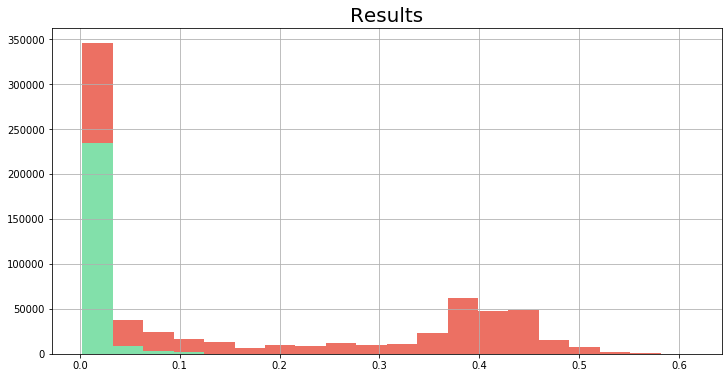

In [29]:
histogram(y_test,y_pred)

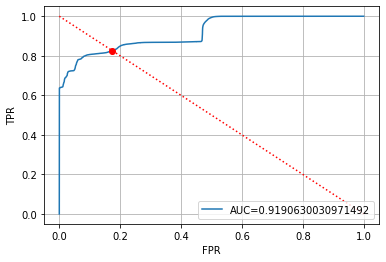

In [30]:
threshold=ROC(y_test,y_pred)

## Anomaly gap maximize net

* 제안 아이디어 검증

In [31]:
class UsadModel_AGM(tf.keras.Model):
    def __init__(self, w_size, z_size, alpha = .5, beta = .5):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
        
        self.latent_vector = self.encoder(self.encoder.model.inputs)
        self.ae_output1 = self.decoder1(self.latent_vector)
        self.ae_output2 = self.decoder2(self.latent_vector)

        self.ae_model1 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output1)
        self.ae_model2 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output2)
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.alpha, self.beta = alpha, beta
        
    def evaluate(self, val_loader, n):
        outputs = [self.validation_step(batch, n) for batch in val_loader]
        return self.validation_epoch_end(outputs)

    def testing(self, test_loader):
        results=[]
        for batch, _ in test_loader:
            w1=self.ae_model1(batch)
            w2=self.ae_model2(w1)
            results.append(self.alpha*np.mean((batch-w1).numpy()**2, axis = 1)+self.beta*np.mean((batch-w2).numpy()**2, axis = 1))
        return results
        
    def call(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        return w1, w2, w3
    
    def loss_fn(self, batch, n) :
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-self.w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-self.w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        
        return loss1, loss2
    
    def training(self, train_loader, val_loader, num_epochs):
        self.history = []
        
        for n in range(num_epochs): 
            n += 1
            
            loss1_list, loss2_list, loss3_list = [], [], []
            
            # Iterate over the batches of a dataset.
            for x_batch_train, y_batch_train in train_loader:
                with tf.GradientTape() as ae1_tape, tf.GradientTape() as ae2_tape, tf.GradientTape() as pg_tape:
                    self.z = self.encoder(x_batch_train)
                    self.w1 = self.decoder1(self.z)
                    self.w2 = self.decoder2(self.z)
                    self.w3 = self.decoder2(self.encoder(self.w1))
                    
                    real_recon1 = x_batch_train-self.w1
                    real_recon2 = x_batch_train-self.w2
                    fake_recon = x_batch_train-self.w3

                    # Loss value for this minibatch
                    loss1, loss2 = self.loss_fn(x_batch_train, n)
                    
                    pg_advantage = tf.stop_gradient(tf.reduce_mean(tf.square(fake_recon))-tf.reduce_mean(tf.square(real_recon2)))
                    loss3 = -tf.reduce_mean(tf.math.log(self.w3+1e-6) * pg_advantage)
        
                    
                    # Add extra losses created during this forward pass:
                    #loss_value += sum(model.losses)

                grads_ae1 = ae1_tape.gradient(loss1, self.ae_model1.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae1, self.ae_model1.trainable_weights))
                grads_ae2 = ae2_tape.gradient(loss2, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae2, self.ae_model2.trainable_weights))
                grads_ae3 = pg_tape.gradient(loss3, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae3, self.ae_model2.trainable_weights))
                
                loss1_list.append(loss1)
                loss2_list.append(loss2)
                loss3_list.append(loss3)
                
            result = self.evaluate(val_loader, n)
            self.epoch_end(n, result)
            self.history.append(result)
                
            #print("Epoch [{}], train_loss1: {:.4f}, train_loss2: {:.4f}, train_loss3: {:.4f}".format(n, np.mean(loss1_list), np.mean(loss2_list), np.mean(loss3_list)))
            
    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        
        real_recon1 = batch-w1
        real_recon2 = batch-w2
        fake_recon = batch-w3
                
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        
        pg_advantage = tf.reduce_mean(tf.square(fake_recon))-tf.reduce_mean(tf.square(real_recon2))
        loss3 = -tf.reduce_mean(tf.math.log(w3+1e-6) * pg_advantage)
        
        return {'val_loss1': loss1, 'val_loss2': loss2, 'val_loss3': loss3}
    
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = tf.reduce_mean(batch_losses1)
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = tf.reduce_mean(batch_losses2)
        batch_losses3 = [x['val_loss3'] for x in outputs]
        epoch_loss3 = tf.reduce_mean(batch_losses3)
        return {'val_loss1': epoch_loss1.numpy(), 'val_loss2': epoch_loss2.numpy(), 'val_loss3': epoch_loss3.numpy()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2'], result['val_loss3']))

In [32]:
usad_agm = UsadModel_AGM(w_size,z_size)

In [ ]:
usad_agm.training(train_loader, val_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [2], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [3], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [4], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: -0.0000
Epoch [5], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [6], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: -0.0000
Epoch [7], val_loss1: 0.0119, val_loss2: 0.0119, val_loss2: -0.0004
Epoch [8], val_loss1: 0.0116, val_loss2: 0.0115, val_loss2: -0.0027
Epoch [9], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: -0.0000
Epoch [10], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [11], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [12], val_loss1: 0.0165, val_loss2: 0.0169, val_loss2: -0.0014
Epoch [13], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [14], val_loss1: 0.0308, val_loss2: 0.0308, val_loss2: 0.0000
Epoch [15], val_loss1: 0.0491, val_loss2: 0.0504, v

In [ ]:
def plot_history_2(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    losses3 = [x['val_loss3'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.plot(losses3, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

In [ ]:
plot_history_2(usad_agm.history)

In [ ]:
usad_agm.encoder.save_weights("usad_agm_encoder.h5")
usad_agm.decoder1.save_weights("usad_agm_decoder1.h5")
usad_agm.decoder2.save_weights("usad_agm_decoder2.h5")

## Testing

In [ ]:
results = model_usad.testing(test_loader)

In [ ]:
y_pred = np.concatenate([np.stack(results[:-1]).flatten(), results[-1].flatten()])
y_test = np.concatenate([np.zeros(windows_normal_test.shape[0]),np.ones(windows_attack.shape[0])])

In [ ]:
histogram(y_test,y_pred)

In [ ]:
threshold=ROC(y_test,y_pred)